<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/eva_emnist_pytorch_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy
import torchvision
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

## Loading Our EMINIST Data

Following two steps are involved : 

1. Loading the dataset from Pytorch
2. Making a dataloader for the dataset

###### Loading the data - EMNIST , split='mnist'

In [3]:
train_set = torchvision.datasets.EMNIST('./',
                                        train=True,
                                        download=True,
                                        split='mnist',
                                        transform=torchvision.transforms.Compose([
                                                                    torchvision.transforms.ToTensor()                                                       
                                        ]))

In [4]:
len(train_set), train_set.targets.bincount()

(60000, tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

###### Let's see the first sample

torch.Size([1, 28, 28])
LABEL :  4


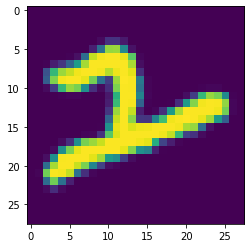

In [5]:
sample = next(iter(train_set))
print(sample[0].shape)
plt.imshow(sample[0].squeeze(0))
print("LABEL : ", sample[1])

###### Making our data loader

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

torch.manual_seed(1)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=1000,
                                           shuffle=True, **kwargs)

In [ ]:
sample = next(iter(train_loader))
len(sample[0]), sample[1]

## Making our Model

In [8]:
torch.set_grad_enabled(False)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) # input - (28 x 28 x 1), Output - (28 x 28 x 10), RF - 3x3
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)  # input - (28 x 28 x 10), Output - (28 x 28 x 20), RF - 5x5
        self.pool1 = nn.MaxPool2d(2, 2)    # input - (28 x 28 x 20), Output - (14 x 14 x 20), RF - 10x10
        self.conv3 = nn.Conv2d(20, 30, 3, padding=1)  # input - (14 x 14 x 20), Output - (14 x 14 x 30), RF - 12x12
        self.conv4 = nn.Conv2d(30, 30, 3, padding=1)  # input - (14 x 14 x 30), Output - (14 x 14 x 30), RF - 14x14
        self.pool2 = nn.MaxPool2d(2, 2)    # input - (14 x 14 x 30), Output - (7 x 7 x 30), RF - 28x28
        self.conv5 = nn.Conv2d(30, 20, 3)  # input - (7 x 7 x 30), Output - (5 x 5 x 20), RF - 30x30
        self.conv6 = nn.Conv2d(20, 10, 3)  # input - (5 x 5 x 20), Output - (3 x 3 x 10), RF - 32x32


    def forward(self, t):
        
        # first pooling layer and 2 convulations
        t = self.conv1(t)
        t = F.relu(t)
        t = self.conv2(t)
        t = F.relu(t)

        t = self.pool1(t)

        # second pooling layer and 2 convulations
        t = self.conv3(t)
        t = F.relu(t)
        t = self.conv4(t)
        t = F.relu(t)

        t = self.pool2(t)

        # last convulation layers
        t = self.conv5(t)
        t = F.relu(t)
        t = self.conv6(t)

        # GAP layer
        out = t.mean(dim=[-2,-1]) # input - (3 x 3 x 10), Output - (1 x 1 x 10), RF - 32x32 -> It is a GAP layer. Implements mean over channel dimensions.

        return F.softmax(out)


###### Testing out model input and outputs on single sample 

In [10]:
sample = next(iter(train_loader))
# len(sample[0]), sample[1]
image, label = sample[0][0], sample[1][0]
image.shape, image.unsqueeze(0).shape

(torch.Size([1, 28, 28]), torch.Size([1, 1, 28, 28]))

In [11]:
model = Model()
pred = model(image.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [12]:
pred, label

(tensor([[0.1035, 0.0960, 0.1066, 0.1041, 0.1007, 0.0972, 0.0979, 0.1008, 0.0972,
          0.0961]]), tensor(1))

In [13]:
pred.argmax(dim=1)

tensor([2])

## Creating a training loop and training the model

In [14]:
torch.set_grad_enabled(True)

In [15]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [16]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(20):
    
    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch:", i, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0 total_correct: 29255 loss: 117.95919871330261
epoch: 1 total_correct: 40077 loss: 107.44942653179169
epoch: 2 total_correct: 40797 loss: 106.6788318157196
epoch: 3 total_correct: 40970 loss: 106.51033985614777
epoch: 4 total_correct: 40801 loss: 106.72469365596771
epoch: 5 total_correct: 42797 loss: 104.70428740978241
epoch: 6 total_correct: 46811 loss: 100.78279328346252
epoch: 7 total_correct: 47106 loss: 100.46633815765381
epoch: 8 total_correct: 47319 loss: 100.19122755527496
epoch: 9 total_correct: 47418 loss: 100.07758128643036
epoch: 10 total_correct: 47526 loss: 99.93885087966919
epoch: 11 total_correct: 50167 loss: 97.40339589118958
epoch: 12 total_correct: 53163 loss: 94.45706915855408
epoch: 13 total_correct: 53232 loss: 94.38677322864532
epoch: 14 total_correct: 53293 loss: 94.3391546010971
epoch: 15 total_correct: 53380 loss: 94.24734461307526
epoch: 16 total_correct: 53379 loss: 94.23817539215088
epoch: 17 total_correct: 53419 loss: 94.19719541072845
epoch: 18 to

As we have seen above. We have trianed the model for 20 epochs and got reduced to loss of 94. Now, to reduce the loss further, we need to select a better model.